# Scenery Classification

In [22]:
# Important imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
from os import listdir
from sklearn.preprocessing import  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from PIL import Image
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, LeakyReLU
from sklearn.model_selection import train_test_split

We will start by importing some required libraries.

In [23]:
# Listing directory
!ls "/Users/skaayth/myprojects/Scenery Classifier/Data"

buildings forest    glacier   mountain  sea       street


We will check for folders of class images.

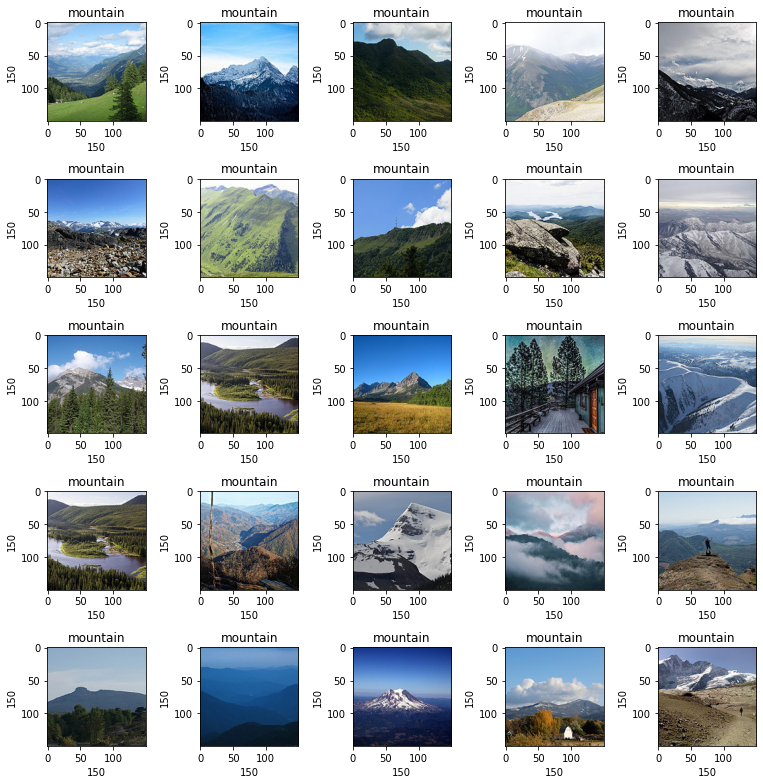

In [24]:
# Plotting 25 images to check dataset
plt.figure(figsize=(11,11))
path = "/Users/skaayth/myprojects/Scenery Classifier/Data/mountain"
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(listdir(path))))
    plt.imshow(rand_img)
    plt.title('mountain')
    plt.xlabel(rand_img.shape[1], fontsize = 10)
    plt.ylabel(rand_img.shape[0], fontsize = 10)

Let's visualize some of the mountain images that we will be working on. Also we will observe x and y dimensions of the image.

In [25]:
# setting a root directory with an empty list
dir = "/Users/skaayth/myprojects/Scenery Classifier/Data"
root_dir = listdir(dir)
image_list, label_list = [], []

Setting the root directory for the dataset and storing all the folders name of the dataset. We will also create 2 empty list for image and lables.

In [27]:
# Reading and converting image to numpy array
for directory in root_dir:
  for files in listdir(f"{dir}/{directory}"):
    image_path = f"{dir}/{directory}/{files}"
    image = Image.open(image_path)
    image = image.resize((150,150)) # All images does not have same dimension
    image = img_to_array(image)
    image_list.append(image)
    label_list.append(directory)

Next we need to resize images as some of the images don't have same dimensions. So, we will read and resize all the images. Then we will convert it into array and appending the list created above with the image and its label.

In [28]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts

glacier      553
mountain     525
sea          510
street       501
forest       474
buildings    437
dtype: int64

Checking for images per class.

In [29]:
# Checking count of classes
num_classes = len(label_counts)
num_classes

6

Storing the number of classes which will be used further in model architecture.

In [30]:
# Checking x data shape
np.array(image_list).shape

(3000, 150, 150, 3)

Check the shape of the x data for input layer of model architecture.

In [31]:
# Checking y data shape
label_list = np.array(label_list)
label_list.shape

(3000,)

Checking the number of labels in y data which should be equal to total number of images.

In [32]:
# Splitting dataset into test and train
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10) 

Now we will split our dataset into testing and training using train_test_split() from sklearn.

In [33]:
# Normalize and reshape data
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 150,150,3)
x_test = x_test.reshape( -1, 150,150,3)

Next we will normalize the images by dividing them with 255 and we will also reshape x_train and x_test data. 

In [34]:
# Binarizing labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
print(lb.classes_)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


Here we will use label binarizer to one hot encode our y data. We will also print the sequence of the classes.

In [35]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

Now we will split the training data to validation and training data.

In [36]:
# Creating model architecture
model = Sequential([
        Conv2D(16, kernel_size = (3,3), input_shape = (150,150,3)),
        BatchNormalization(),
        LeakyReLU(),
          
        Conv2D(32, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(5,5),
        
        Conv2D(64, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2D(128, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(5,5),

        Flatten(),
    
        Dense(64),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(),
        
        Dense(32),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(),
    
        Dense(16),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(1),
    
        Dense(6, activation = 'softmax')    
        ])
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 16)     64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 148, 148, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 146, 146, 32)     128       
 hNormalization)                                                 
                                         

2022-01-23 15:40:49.869285: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-23 15:40:49.869424: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [37]:
# Compiling model
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0005),metrics=['accuracy'])

In [38]:
# Training the model
epochs = 70
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))

2022-01-23 15:40:59.187431: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/70


2022-01-23 15:40:59.539267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 1.5464 - accuracy: 0.3990

2022-01-23 15:41:08.508860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 10s 275ms/step - loss: 1.5464 - accuracy: 0.3990 - val_loss: 1.7738 - val_accuracy: 0.1875
Epoch 2/70
15/15 [==============================] - 4s 254ms/step - loss: 1.2108 - accuracy: 0.5615 - val_loss: 1.8983 - val_accuracy: 0.2875
Epoch 3/70
15/15 [==============================] - 4s 247ms/step - loss: 1.0188 - accuracy: 0.6594 - val_loss: 1.9386 - val_accuracy: 0.2563
Epoch 4/70
15/15 [==============================] - 4s 254ms/step - loss: 0.9342 - accuracy: 0.6948 - val_loss: 1.9762 - val_accuracy: 0.2271
Epoch 5/70
15/15 [==============================] - 4s 246ms/step - loss: 0.8516 - accuracy: 0.7266 - val_loss: 1.9976 - val_accuracy: 0.2958
Epoch 6/70
15/15 [==============================] - 4s 245ms/step - loss: 0.7888 - accuracy: 0.7563 - val_loss: 2.0430 - val_accuracy: 0.3229
Epoch 7/70
15/15 [==============================] - 4s 244ms/step - loss: 0.7122 - accuracy: 0.7917 - val_loss: 2.0398 - val_accuracy: 0.2667
Epoch 8/70
15/15

In [ ]:
# Saving model
model.save("/Users/skaayth/myprojects/Scenery Classifier/app/static/model/sceneclassifier.h5")

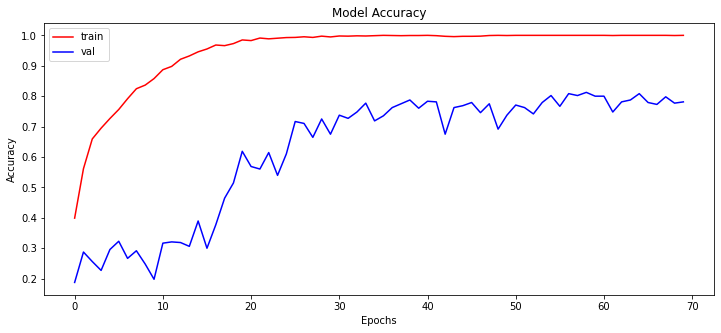

In [39]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

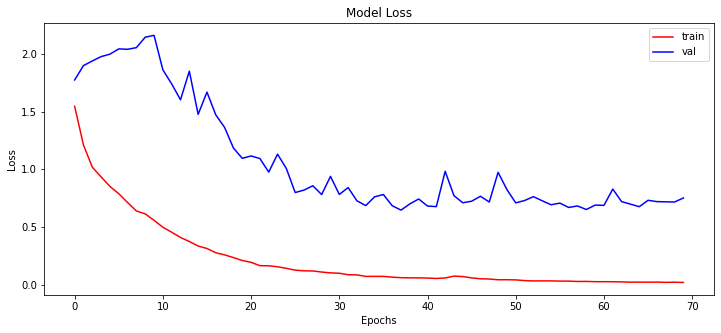

In [40]:
#Plot the loss history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [41]:
# Calculating test accuracy 
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

19/19 [==============================] - 0s 24ms/step - loss: 0.7445 - accuracy: 0.7750
Test Accuracy: 77.50000357627869


Evaluating the model to know the accuracy of the model on the test data.

In [42]:
# Storing model predictions
y_pred = model.predict(x_test)

2022-01-23 15:46:19.088102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Generating predictions for test data and storing them into y_pred.

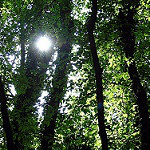

In [43]:
# Plotting image to compare
img = array_to_img(x_test[1])
img

Visualizing an image to be predicted in further steps.

In [44]:
# Finding max value from predition list and comaparing original value vs predicted
labels = lb.classes_
print(labels)
print("Originally : ",labels[np.argmax(y_test[1])])
print("Predicted : ",labels[np.argmax(y_pred[1])])

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']
Originally :  forest
Predicted :  forest


Now, we will create list of labels using object of label binarizer. We will print that list and finally we will print out the prediction and the original label of the image we visualized above using argmax().